# Model Building

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

#ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

Now we are using cleaned data file for model building

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/PES1UG20CS594/da_project/data_cleaned.csv')
data.shape

(229505, 26)

In [5]:
data.head()

,region,price,type,sqfeet,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,...,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
0,3.0,7.021084,3.0,7.184629,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3.0,6.715383,3.0,7.032624,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,3.0,6.684612,3.0,6.831954,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,3.0,6.665684,3.0,6.953684,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,3.0,6.802395,3.0,7.168580,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    data.drop('price',axis=1),
                                    data['price'],
                                    test_size=0.25,
                                    random_state=0)

***Data Split 1: all of our final dataset, no scaling***

In [7]:
y = data['price']
X = data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

***Data Split 2: all of our final dataset, with scaling***

In [8]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## Linear Regression

From our EDA, we can see that most features do not have a linear relationship with our labels (gdp_per_capita), yet we will try linear regression, and use the result as a reference (other methods should have better results).

***Model Training***

In [9]:
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

LinearRegression()

***Predictions***

In [10]:
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)

***Evaluation***

Linear Regression Performance:

all features, No scaling:
MAE: 0.26568055036883126
RMSE: 0.4466787722707824
R2_Score:  0.14582083033688875

all features, with scaling:
MAE: 0.26542875124451987
RMSE: 0.4466241403969642
R2_Score:  0.14602976148724733


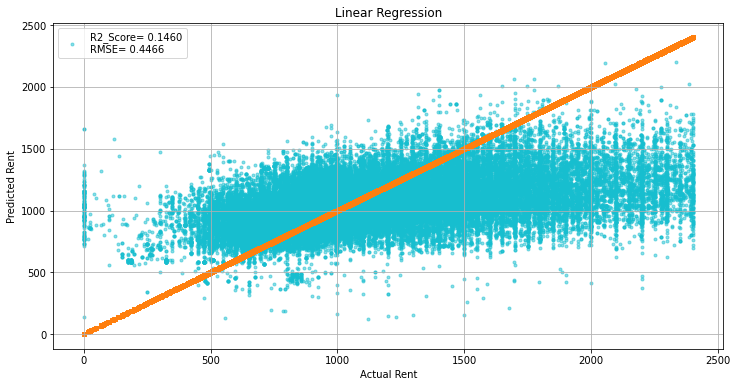

In [11]:
print('Linear Regression Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, lm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, lm1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, lm2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, lm2_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(lm2_pred), 'Actual_Rent': np.exp(y2_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y2_test, lm2_pred), 
                np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
           ],
           loc='best')
plt.title('Linear Regression')
plt.grid()
plt.show()

The orange line in the graph represents the actual rents. And the cyan circles plotted against actual rents, on the x-axis, are the predicted rents.

Linear Model worked terribly, which was expected as there were no linear relationship among the features. Feature scaling has a small positive effect on LR's prediction performance.

## Random Forest

Let's first try random forest with our data splits (with and without feature selection). Scaling the features should not affect this algorithm's performance, still we are going to test it. later we will try to improve its performance.

***Model Training***

In [12]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(n_estimators=200, random_state=101)

***Predictions***

In [13]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)

***Evaluation***

Random Forest Performance:

all features, No scaling:
MAE: 0.06156701627109237
RMSE: 0.1889480535777893
R2_Score:  0.8471578304659768

all features, with scaling:
MAE: 0.11631547349878206
RMSE: 0.29974972661432736
R2_Score:  0.6153409628777649


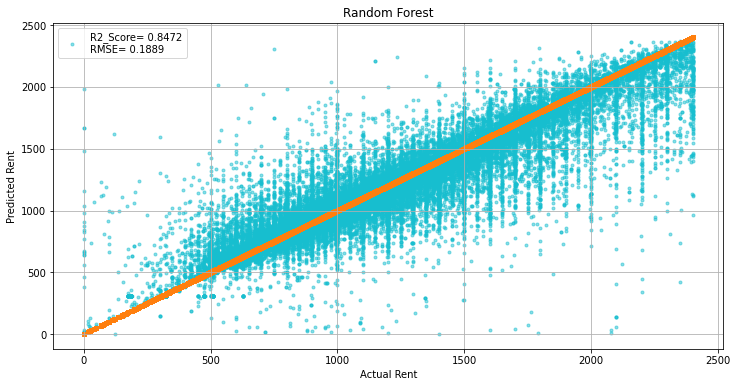

In [14]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, rf2_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(rf1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, rf1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
           ],
           loc='best')
plt.title('Random Forest')
plt.grid()
plt.show()

Features without scaling gave a better result on random forest than with scaled features

## Gradient Boosting

***Training***

In [15]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, 
                                 min_samples_leaf=1, max_depth=3, subsample=1.0, max_features= None, 
                                 random_state=101)

gbm1.fit(X_train, y_train)

GradientBoostingRegressor(random_state=101)

***Predictions***

In [16]:
gbm1_pred = gbm1.predict(X_test)

***Evaluation***

Gradiant Boosting Performance:

all features, No scaling:
MAE: 0.17528928720284018
RMSE: 0.3129626446851609
R2_Score:  0.5806821454650817


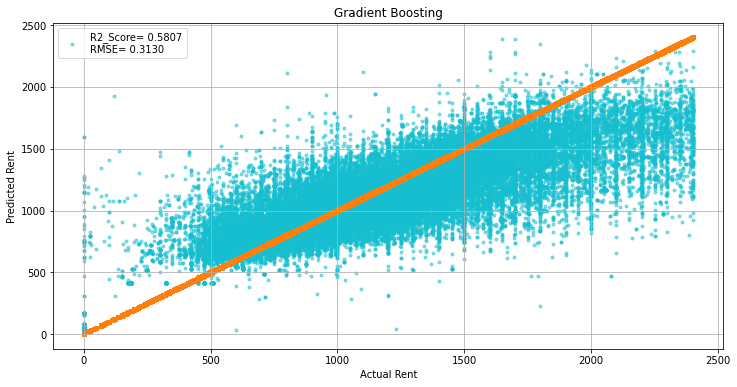

In [17]:
print('Gradiant Boosting Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, gbm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, gbm1_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(gbm1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, gbm1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, gbm1_pred)))
           ],
           loc='best')
plt.title('Gradient Boosting')
plt.grid()
plt.show()

It is clear that Gradiant Boosting gave us a very poor performance, compared to Random Forest. So not opting for an optimization.

## XgBoost

***Model Training***

We will train the xgboost regressor with the default parameter values

In [18]:
xgb1 = XGBRegressor(learning_rate=0.1, n_estimators=100, 
                    min_samples_split=2, min_samples_leaf=1, 
                    max_depth=3, subsample=1.0, random_state=101)

xgb1.fit(X_train, y_train)

[05:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(min_samples_leaf=1, min_samples_split=2, random_state=101,
             subsample=1.0)

***Predictions***

In [19]:
xgb1_pred = xgb1.predict(X_test)

***Evaluation***

XgBoost Performance:

all features, No scaling:
MAE: 0.1774857555740322
RMSE: 0.32945435429617104
R2_Score:  0.5353254869375011


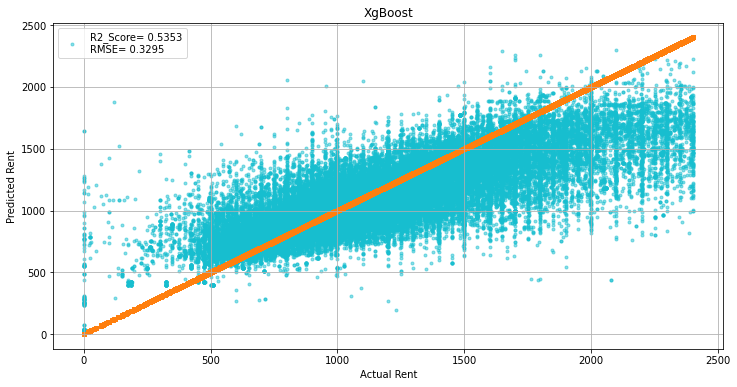

In [20]:
print('XgBoost Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, xgb1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, xgb1_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(xgb1_pred), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(y_test, xgb1_pred), 
                np.sqrt(metrics.mean_squared_error(y_test, xgb1_pred)))
           ],
           loc='best')
plt.title('XgBoost')
plt.grid()
plt.show()

XgBoost also performed poorly. So will not be optimizing.

## Conclusion

In this project, we used house rent dataset to build a monthly rent predictor. 4 different learning regressors (Linear Regression, Random Forest, Gradiant Boosting, and XgBoost) were tested, and we have acheived the best prediction performance using Random Forest, followed by Gradiant Boosting, and then XgBoost, while Linear Regression, acheived the worst performance of the 4.

The best prediction performance was acheived using Random Forest regressor, using all features in the dataset, and resulted in the following metrics:

- Mean Absolute Error (MAE): 0.0591
- Root mean squared error (RMSE): 0.1717
- R-squared Score (R2_Score): 0.8746